In [1]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

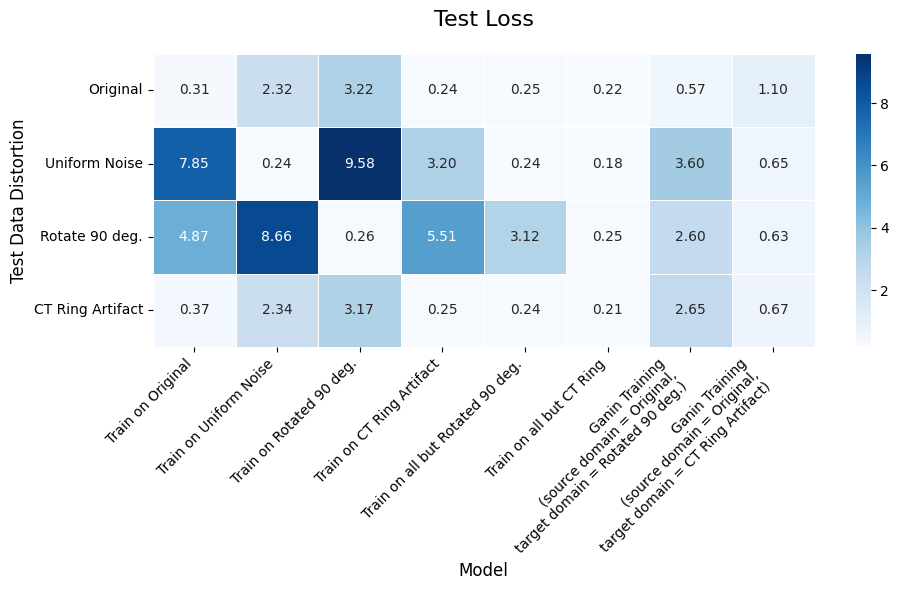

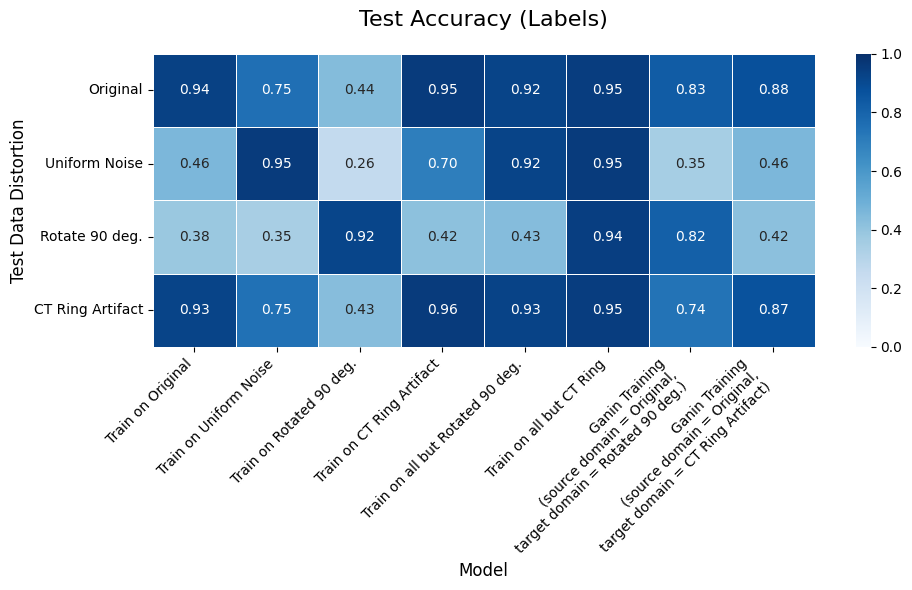

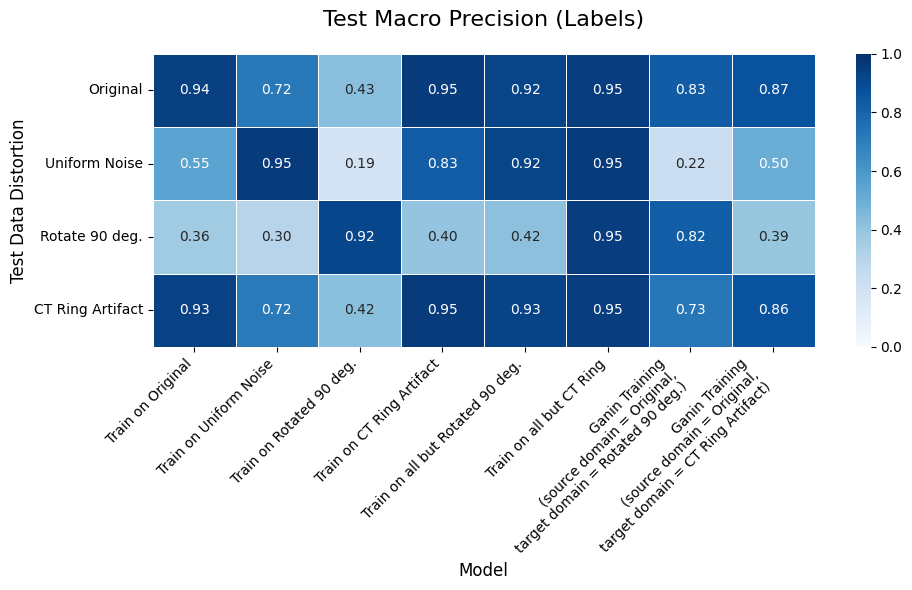

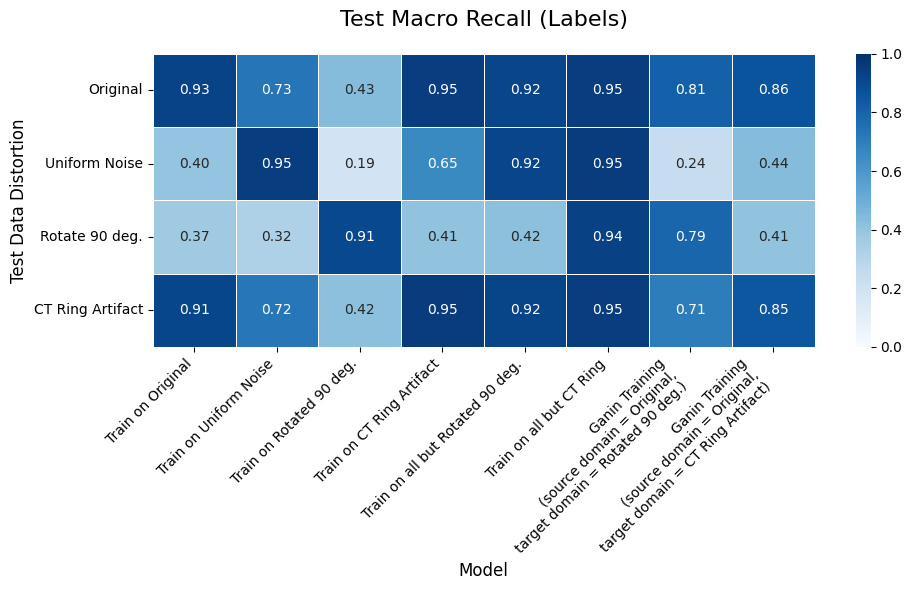

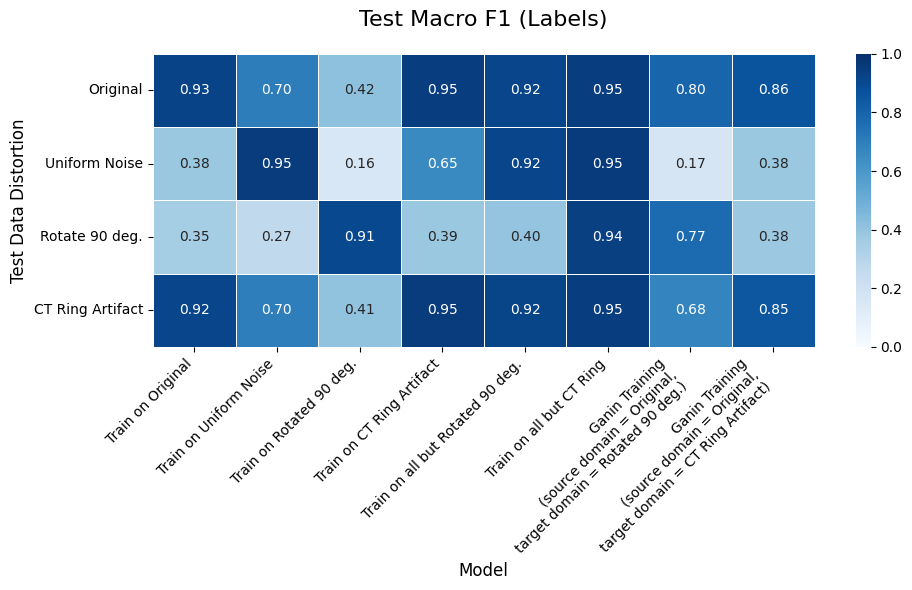

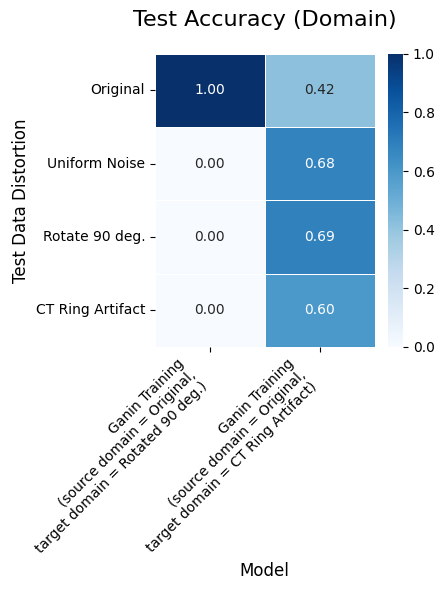

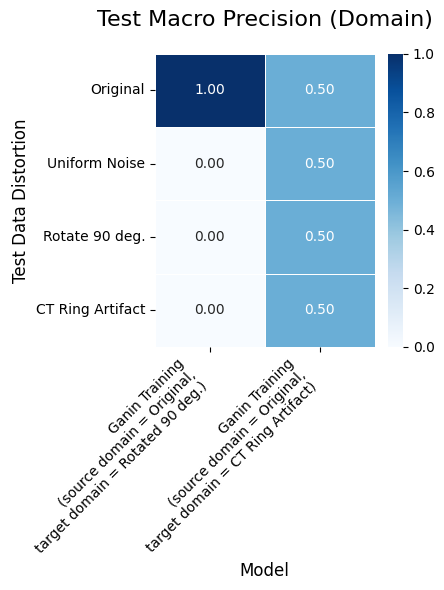

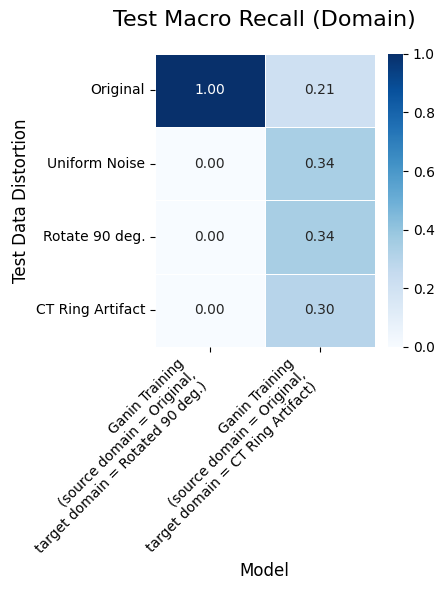

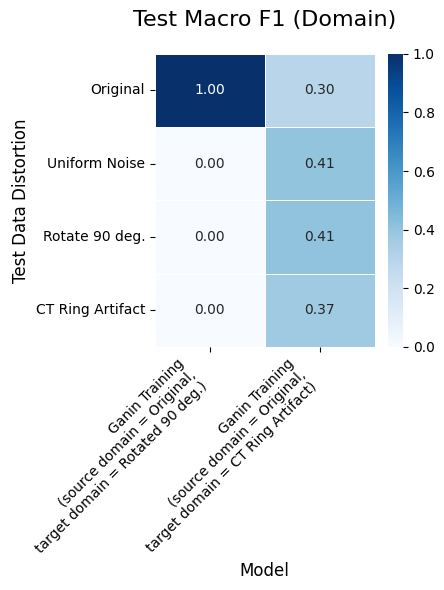

In [4]:
## Get test results

TEST_ROOT = "./metric_csvs/test_results"

def df_to_heatmap(df, ttl, vmin=0, vmax=1, figsize=None):
    if figsize==None:
        figsize=(10,6)
    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        df,
        cmap="Blues",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        # cbar_kws={"label": "Accuracy"},
        vmin=vmin,
        vmax=vmax,
    )

    # Titles and axis labels
    plt.title(ttl, fontsize=16, pad=20)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Test Data Distortion", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Layout
    plt.tight_layout()
    plt.savefig("figs/" + ttl + ".png")
    plt.show()

def get_test_figs():
    test_results_fname_to_std_model_name = {
        "A_original_test_results.csv": "A10",
        "A_uniform_test_results.csv": "A11",
        "A_rotate_test_results.csv": "A12",
        "A_ring_test_results.csv": "A13",
        "C11_test_results.csv": "C11",
        "C10_test_results.csv": "C10",
        "D20_test_results_from_screenshots.csv": "D20", # manually transcribed from Sam's screenshots
        "D21_test_results_from_screenshots.csv": "D21", # manually transcribed from Sam's screenshots
    }

    test_results_fname_to_readable_model_name = {
        "A_original_test_results.csv": "Train on Original",
        "A_uniform_test_results.csv": "Train on Uniform Noise",
        "A_rotate_test_results.csv": "Train on Rotated 90 deg.",
        "A_ring_test_results.csv": "Train on CT Ring Artifact",
        "C11_test_results.csv": "Train on all but Rotated 90 deg.",
        "C10_test_results.csv": "Train on all but CT Ring",
        "D20_test_results_from_screenshots.csv": "Ganin Training\n(source domain = Original,\ntarget domain = Rotated 90 deg.)", # manually transcribed from Sam's screenshots
        "D21_test_results_from_screenshots.csv": "Ganin Training\n(source domain = Original,\ntarget domain = CT Ring Artifact)", # manually transcribed from Sam's screenshots
    }

    test_results_metric_to_std_metric_name = {
        "eval_loss": "Test Loss",
        "eval_accuracy": "Test Accuracy (Labels)",
        "eval_precision": "Test Macro Precision (Labels)",
        "eval_recall": "Test Macro Recall (Labels)",
        "eval_f1": "Test Macro F1 (Labels)",
        "eval_accuracy_d": "Test Accuracy (Domain)",
        "eval_precision_d": "Test Macro Precision (Domain)",
        "eval_recall_d": "Test Macro Recall (Domain)",
        "eval_f1_d": "Test Macro F1 (Domain)",
    }
    test_results_index_to_std_test_name = {
        "original": "Original",
        "Uniform_Noise": "Uniform Noise",
        "Rotate_90deg": "Rotate 90 deg.",
        "Ring_Artifact_v1": "CT Ring Artifact",
    }

    metric_tables = {}
    for metric in ["eval_loss", "eval_accuracy", "eval_precision", "eval_recall", "eval_f1", 
                                "eval_accuracy_d", "eval_precision_d", "eval_recall_d", "eval_f1_d"]:
        metric_std_name = test_results_metric_to_std_metric_name[metric]
        metric_tables[metric_std_name] = {}
        for fname in os.listdir(TEST_ROOT):
            if ".csv" in fname:
                df = pd.read_csv(os.path.join(TEST_ROOT, fname), index_col="test_set")
                if metric in df.columns:
                    metric_tables[metric_std_name][fname] = df[metric]

    df_dict = {}
    for outer_key, inner_dict in metric_tables.items():
        if not all(isinstance(s, pd.Series) for s in inner_dict.values()):
            raise ValueError
        df = pd.DataFrame(inner_dict)
        df = df.rename(columns=test_results_fname_to_readable_model_name, index=test_results_index_to_std_test_name)
        df.index.name = "TestSet"
        df = df.reindex(columns=test_results_fname_to_readable_model_name.values(), index=test_results_index_to_std_test_name.values())
        df_dict[outer_key] = df

    for metric in test_results_metric_to_std_metric_name.values():
        if "Loss" in metric:
            df_to_heatmap(df_dict[metric], metric, vmin=None, vmax=None)
        elif "Domain" in metric:
            df_to_heatmap(df_dict[metric].dropna(axis=1, how='any'), metric, figsize=(4.5,6))
        else:
            df_to_heatmap(df_dict[metric], metric)

    return df_dict
test_results = get_test_figs()

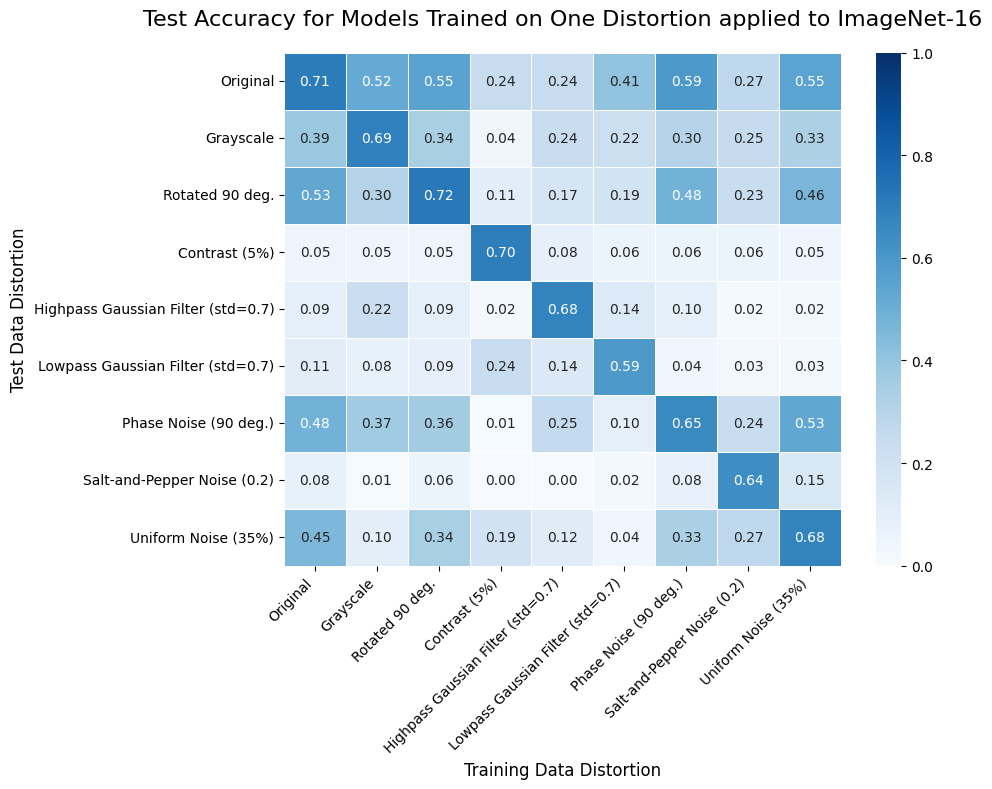

In [3]:
# Analogous table for ImageNet
def get_test_figs_imagenet(fname = "Distortion_val_Matrix.csv"):
    VAL_ROOT = "metric_csvs/VAL RESULTS"
    df = pd.read_csv(os.path.join(VAL_ROOT, fname), index_col=0)

    distortion_labels = {
        "cropped_224": "Original",
        "cropped_224_gray": "Grayscale",
        "cropped_224_rotated": "Rotated 90 deg.",
        "cropped_contrast_5": "Contrast (5%)",
        "highpass_0.7": "Highpass Gaussian Filter (std=0.7)",
        "lowpass_7": "Lowpass Gaussian Filter (std=0.7)",
        "phase_scrambled_90": "Phase Noise (90 deg.)",
        "saltpepper_0.2": "Salt-and-Pepper Noise (0.2)",
        "uniform_035": "Uniform Noise (35%)",
    }

    df = df.rename(columns=distortion_labels,index=distortion_labels)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df,
        cmap="Blues",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        # cbar_kws={"label": "Accuracy"},
        vmin=0,
        vmax=1,
    )

    # Titles and axis labels
    ttl = "Test Accuracy for Models Trained on One Distortion applied to ImageNet-16"
    plt.title(ttl, fontsize=16, pad=20)
    plt.xlabel("Training Data Distortion", fontsize=12)
    plt.ylabel("Test Data Distortion", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Layout
    plt.tight_layout()
    plt.savefig("figs/"+ttl+".png")
    plt.show()

get_test_figs_imagenet()

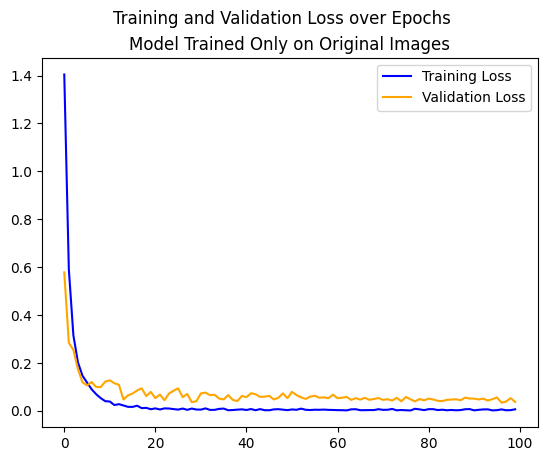

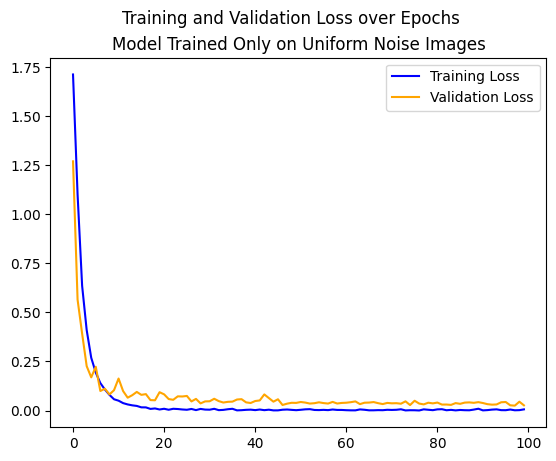

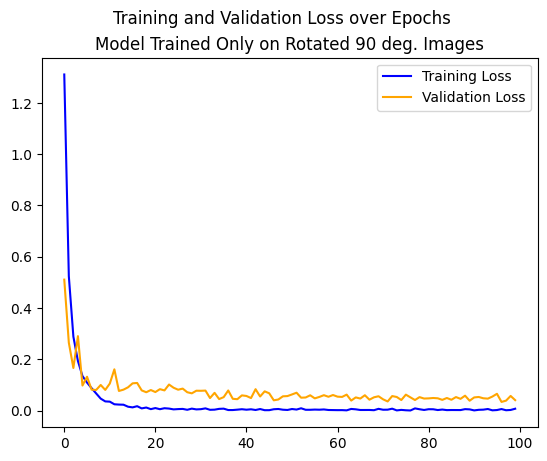

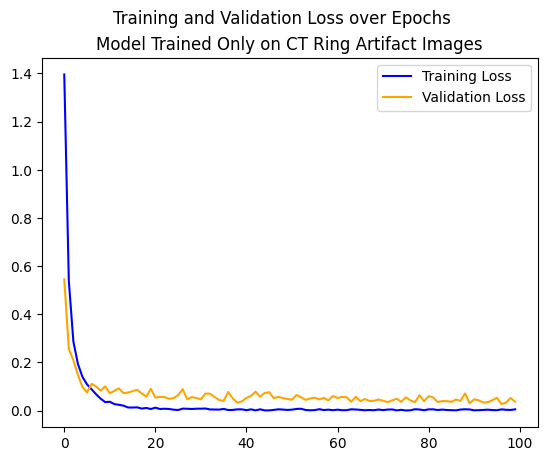

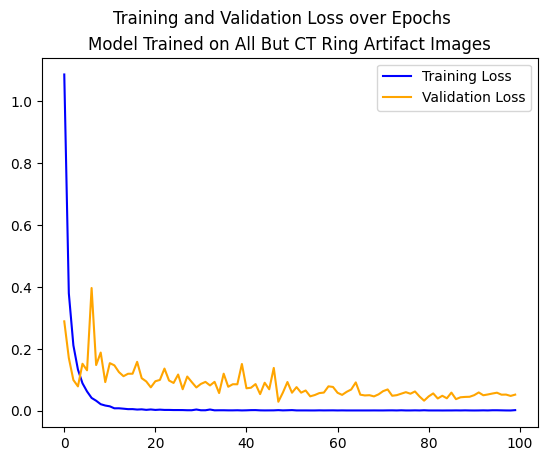

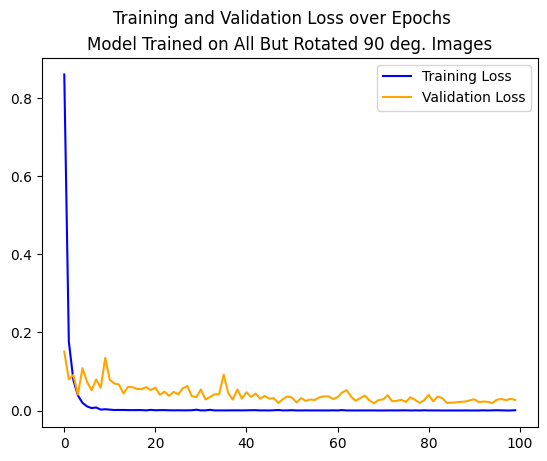

In [4]:
# Get training & appropriate val loss curves
def get_training_loss(fname):
    TRAIN_ROOT = "metric_csvs/VAL RESULTS"
    df = pd.read_csv(os.path.join(TRAIN_ROOT, fname))
    return df["loss"]

def get_val_loss(fname):
    VAL_ROOT = "metric_csvs/VAL RESULTS"
    df = pd.read_csv(os.path.join(VAL_ROOT, fname))
    return df["eval_loss"]

# Get training loss curves
a10_train = get_training_loss("a_original_val_original.csv")
a10_val10 = get_val_loss("a_original_val_original.csv")
a10_val11 = get_val_loss("a_original_val_Uniform_Noise.csv")
a10_val12 = get_val_loss("a_original_val_Rotate_90deg.csv")
a10_val13 = get_val_loss("a_original_val_Ring_Artifact_v1.csv")

a11_train = get_training_loss("a_uniform_noise_val_Uniform_Noise.csv")
a11_val10 = get_val_loss("a_uniform_noise_val_original.csv")
a11_val11 = get_val_loss("a_uniform_noise_val_Uniform_Noise.csv")
a11_val12 = get_val_loss("a_uniform_noise_val_Rotate_90deg.csv")
a11_val13 = get_val_loss("a_uniform_noise_val_Ring_Artifact_v1.csv")

a12_train = get_training_loss("a_rotate_90_val_Rotate_90deg.csv")
a12_val10 = get_val_loss("a_rotate_90_val_original.csv")
a12_val11 = get_val_loss("a_rotate_90_val_Uniform_Noise.csv")
a12_val12 = get_val_loss("a_rotate_90_val_Rotate_90deg.csv")
a12_val13 = get_val_loss("a_rotate_90_val_Ring_Artifact_v1.csv")

a13_train = get_training_loss("a_ring_val_Ring_Artifact_v1.csv")
a13_val10 = get_val_loss("a_ring_val_original.csv")
a13_val11 = get_val_loss("a_ring_val_Uniform_Noise.csv")
a13_val12 = get_val_loss("a_ring_val_Rotate_90deg.csv")
a13_val13 = get_val_loss("a_ring_val_Ring_Artifact_v1.csv")

c10_train = get_training_loss("C10_val_original.csv")
c10_val10 = get_val_loss("C10_val_original.csv")
c10_val11 = get_val_loss("C10_val_Uniform_Noise.csv")
c10_val12 = get_val_loss("C10_val_Rotate_90deg.csv")
c10_val13 = get_val_loss("C10_val_Ring_Artifact_v1.csv")

c11_train = get_training_loss("C11_val_original.csv")
c11_val10 = get_val_loss("C11_val_original.csv")
c11_val11 = get_val_loss("C11_val_Uniform_Noise.csv")
c11_val12 = get_val_loss("C11_val_Rotate_90deg.csv")
c11_val13 = get_val_loss("C11_val_Ring_Artifact_v1.csv")

def show_loss_curves(traincurve, valcurve, ttl):
    plt.figure()
    plt.plot(traincurve, color = "blue", label = "Training Loss")
    plt.plot(valcurve, color = "orange", label = "Validation Loss")
    plt.legend()
    supttl = "Training and Validation Loss over Epochs"
    plt.suptitle(supttl)
    plt.title(ttl)
    plt.savefig("figs/"+supttl+" "+ttl+".png")
    plt.show()

show_loss_curves(a10_train, a10_val10, "Model Trained Only on Original Images")
show_loss_curves(a11_train, a11_val11, "Model Trained Only on Uniform Noise Images")
show_loss_curves(a12_train, a12_val12, "Model Trained Only on Rotated 90 deg. Images")
show_loss_curves(a13_train, a13_val13, "Model Trained Only on CT Ring Artifact Images")
show_loss_curves(c10_train, c10_val10, "Model Trained on All But CT Ring Artifact Images")
show_loss_curves(c11_train, c11_val10, "Model Trained on All But Rotated 90 deg. Images")


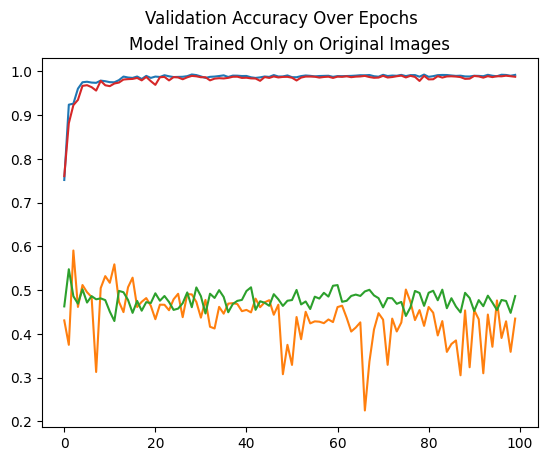

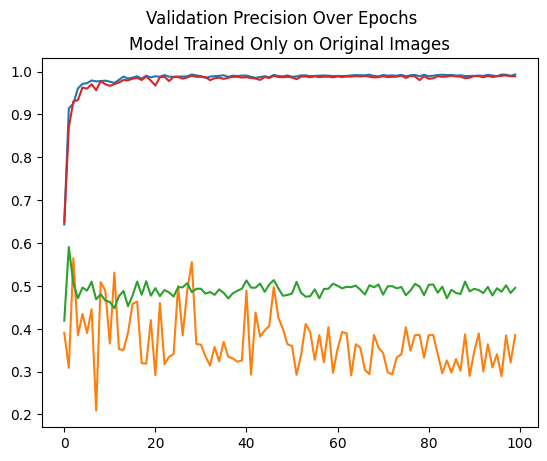

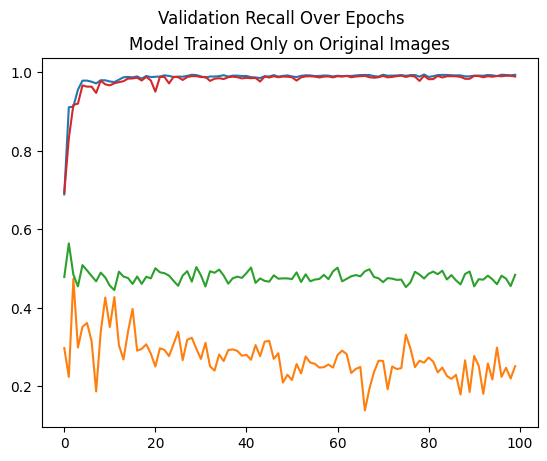

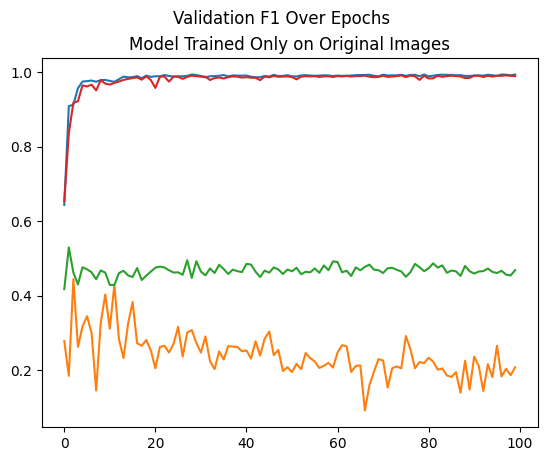

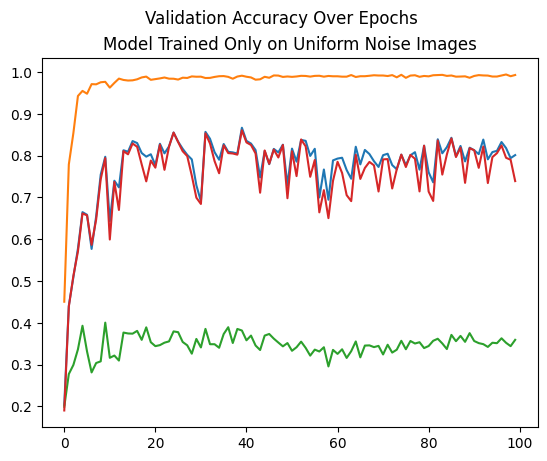

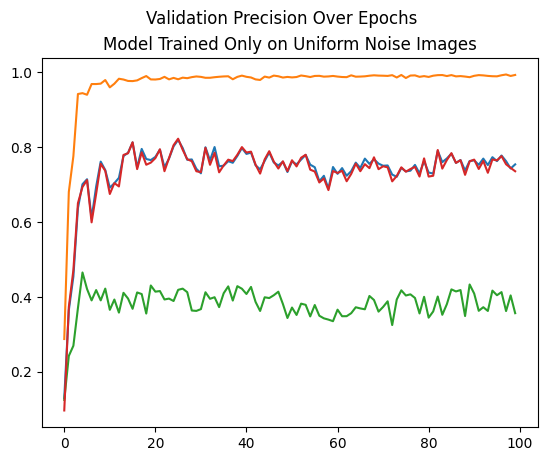

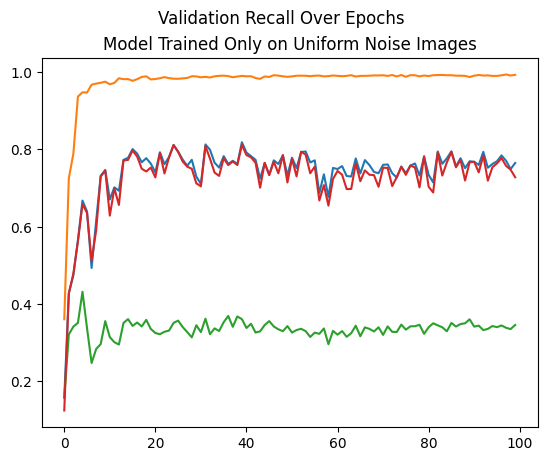

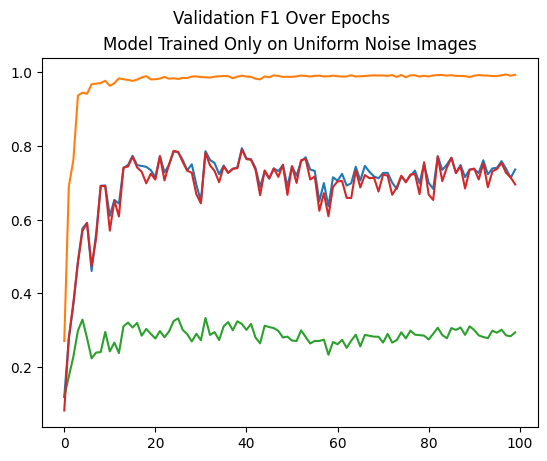

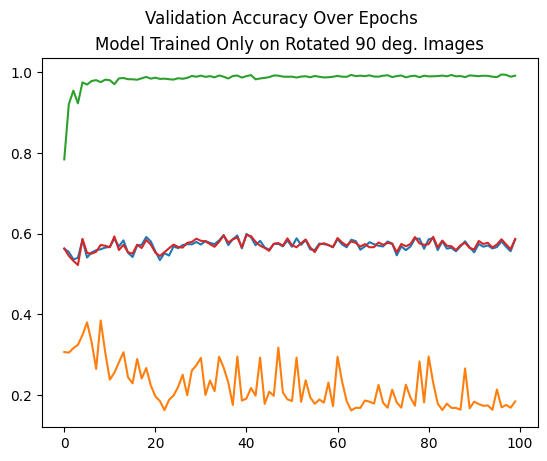

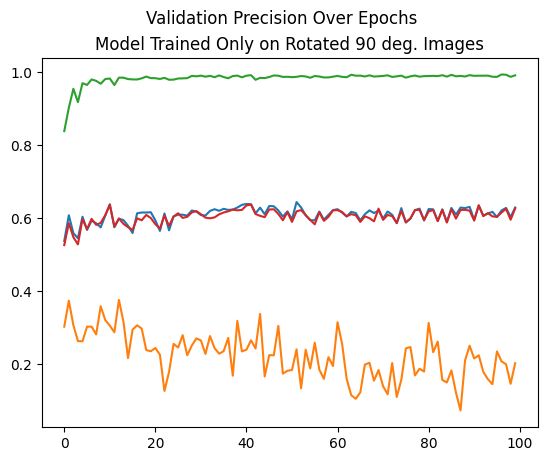

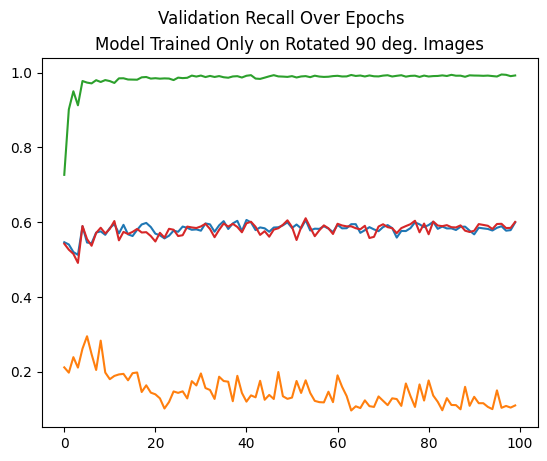

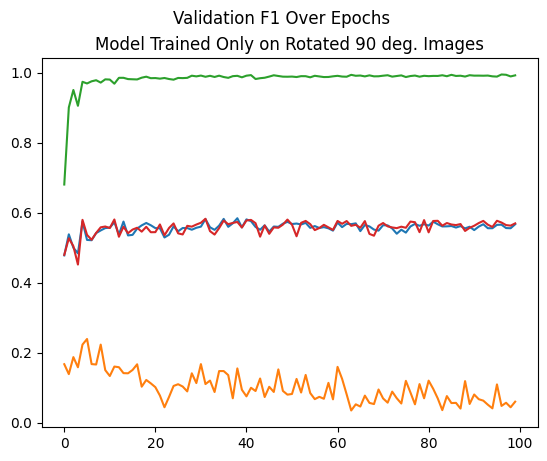

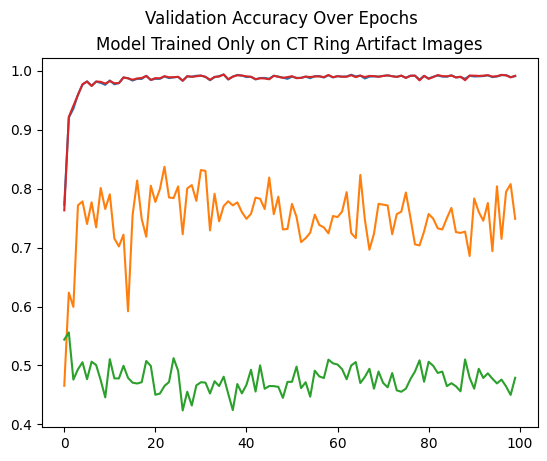

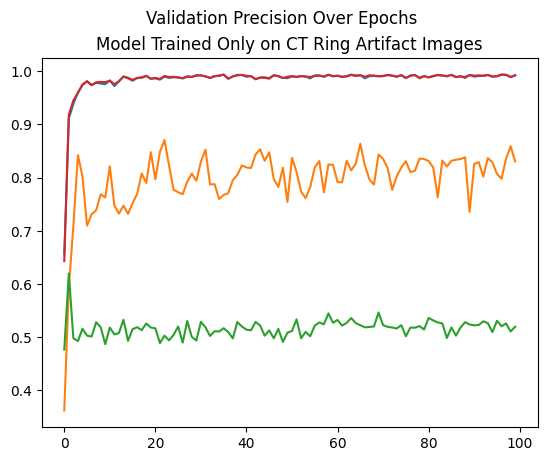

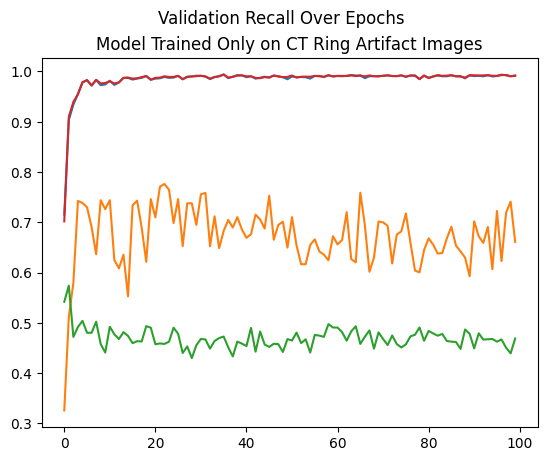

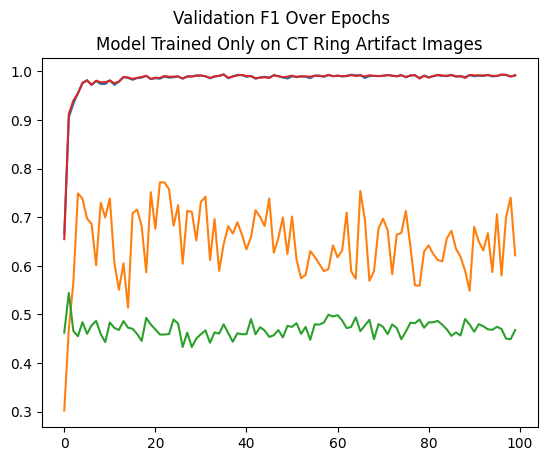

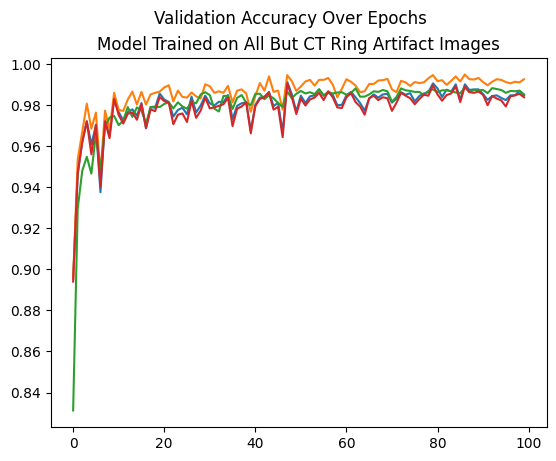

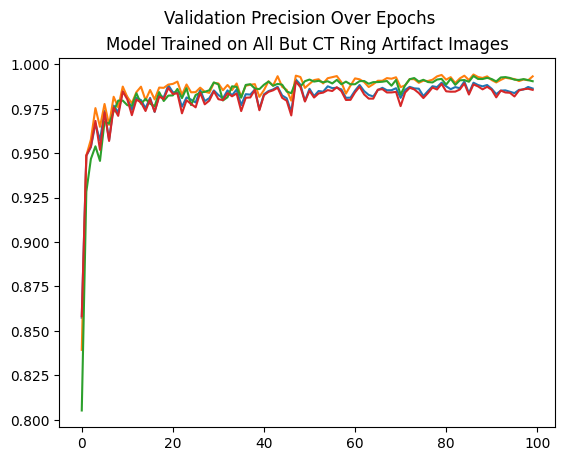

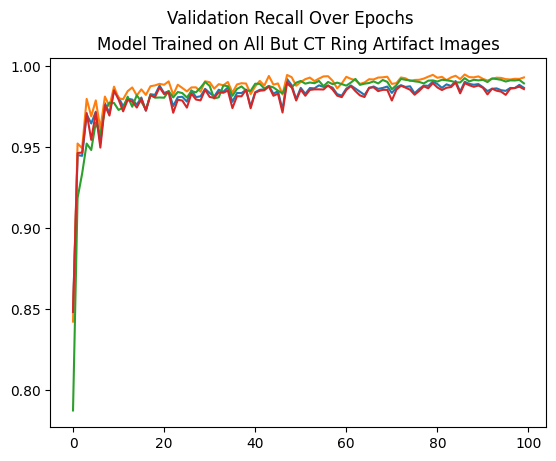

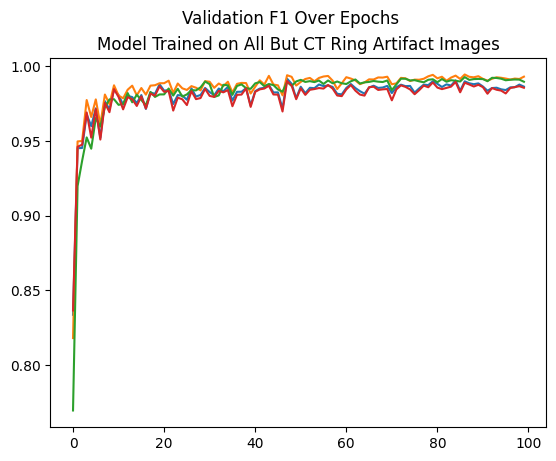

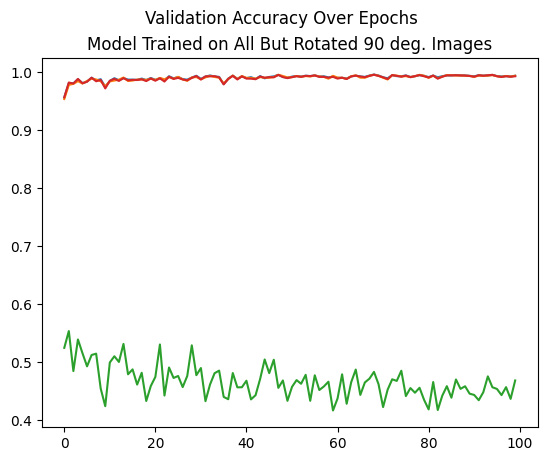

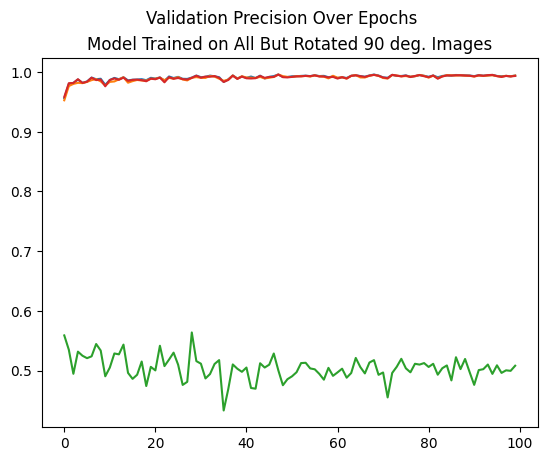

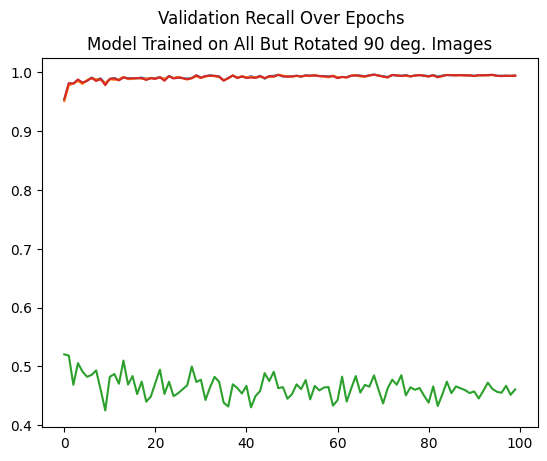

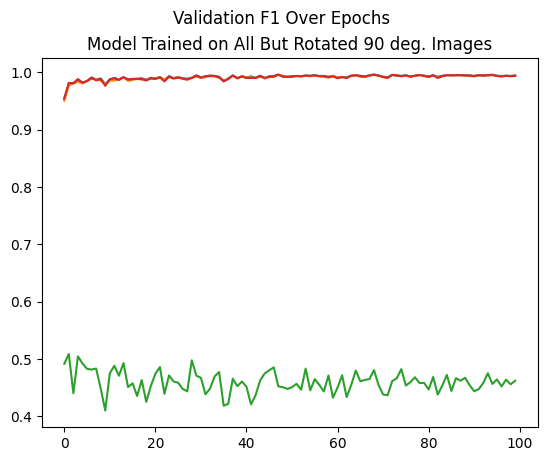

In [5]:



def get_field(fname, field):
    VAL_ROOT = "metric_csvs/VAL RESULTS"
    df = pd.read_csv(os.path.join(VAL_ROOT, fname))
    return df[field]

field_to_ttl = {
    "eval_accuracy": "Validation Accuracy Over Epochs",
    "eval_precision": "Validation Precision Over Epochs",
    "eval_recall": "Validation Recall Over Epochs",
    "eval_f1": "Validation F1 Over Epochs",
}

filename_to_desc = {
    "a_original": "Model Trained Only on Original Images",
    "a_uniform_noise": "Model Trained Only on Uniform Noise Images",
    "a_rotate_90": "Model Trained Only on Rotated 90 deg. Images",
    "a_ring": "Model Trained Only on CT Ring Artifact Images",
    "C10": "Model Trained on All But CT Ring Artifact Images",
    "C11": "Model Trained on All But Rotated 90 deg. Images",
}

target_to_targetname = {
    "original": "Original",
    "Uniform_Noise": "Uniform Noise",
    "Rotate_90deg": "Rotate 90 deg.",
    "Ring_Artifact_v1": "CT Ring Artifact",
}

for filename, desc in filename_to_desc.items():
    for field, ttl in field_to_ttl.items():
        plt.figure()
        plt.suptitle(ttl)
        plt.title(desc)

        for target, targetname in target_to_targetname.items():
            plt.plot(get_field(f"{filename}_val_{target}.csv", field), label = "Validate On " +targetname)

        plt.savefig("figs/"+ttl+" "+desc+" Validate On "+targetname+".png")
        plt.show()






In [6]:
def trainer_state_json_to_df(trainer_state_json):
    VAL_ROOT = "metric_csvs/VAL RESULTS"
    with open(os.path.join(VAL_ROOT, trainer_state_json), 'r') as f:
        data = json.load(f)
    full_epochs = [entry for entry in data["log_history"] if 'eval_loss' in entry]
    df = pd.DataFrame(full_epochs)
    df = df[[]]
    return df

df_d20 = trainer_state_json_to_df("trainer_state_d20.json")
df_d21 = trainer_state_json_to_df("trainer_state_d21.json")